# Project Description

In this project, the aim is to harness the predictive power of a Multi-Layer Perceptron (MLP) classifier, a class of feedforward artificial neural network, to analyze and classify sequences from a DNA dataset. The primary objective is to accurately categorize small segments of DNA into their respective nucleotide bases—adenine (A), cytosine (C), guanine (G), and thymine (T). Utilizing an MLP Classifier's robust neural net architecture, we anticipate achieving high accuracy in classification tasks with relatively short training durations, transforming complex biological data into actionable insights with potential applications in genomics and bioinformatics.

## Importing Libraries and Data Collection

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Importing the necessary libraries and loading promoter gene sequence data

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
import pickle
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/molecular-biology/promoter-gene-sequences/promoters.data'
names = ['Class', 'ID', 'Sequence']
data = pd.read_csv(url, names=names)

## Preprocessing Data

In [3]:
# Display the first 5 rows
data.head()

,Class,ID,Sequence
0,+,S10,\t\ttactagcaatacgcttgcgttcggtggttaagtatgtataat...
1,+,AMPC,\t\ttgctatcctgacagttgtcacgctgattggtgtcgttacaat...
2,+,AROH,\t\tgtactagagaactagtgcattagcttatttttttgttatcat...
3,+,DEOP2,\taattgtgatgtgtatcgaagtgtgttgcggagtagatgttagaa...
4,+,LEU1_TRNA,\ttcgataattaactattgacgaaaagctgaaaaccactagaatgc...


In [4]:
# Our DataFrame has 106 rows and 3 columns
data.shape

(106, 3)

In [5]:
data.dtypes

Class       object
ID          object
Sequence    object
dtype: object

In [6]:
# Understanding the distribution of occurrences of Class (+: Person Has Ecoli, -: Person does not have Ecoli)

classes = data.loc[:, 'Class']
print(classes.value_counts())

+    53
-    53
Name: Class, dtype: int64


In [7]:
# Generate a list of DNA Sequence

sequence = list(data.loc[:, 'Sequence'])
sequence[-1]

'\t\ttaacattaataaataaggaggctctaatggcactcattagccaatcaatcaagaact'

In [8]:
# Remove tab from each sequence
dic = {}
for i, seq in enumerate(sequence):
  nucleotides = list(seq)
  nucleotides = [char for char in nucleotides if char != '\t']
  #append classes
  nucleotides.append(classes[i])

  dic[i] = nucleotides
list(dic[0])

['t',
 'a',
 'c',
 't',
 'a',
 'g',
 'c',
 'a',
 'a',
 't',
 'a',
 'c',
 'g',
 'c',
 't',
 't',
 'g',
 'c',
 'g',
 't',
 't',
 'c',
 'g',
 'g',
 't',
 'g',
 'g',
 't',
 't',
 'a',
 'a',
 'g',
 't',
 'a',
 't',
 'g',
 't',
 'a',
 't',
 'a',
 'a',
 't',
 'g',
 'c',
 'g',
 'c',
 'g',
 'g',
 'g',
 'c',
 't',
 't',
 'g',
 't',
 'c',
 'g',
 't',
 '+']

In [9]:
# Convert Dictionary into DataFrame and Transpose into the correct format
# Each row corresponds to a sequence and class

df = pd.DataFrame(dic).T
df.head()

,0,1,2,3,4,5,6,7,8,9,...,48,49,50,51,52,53,54,55,56,57
0,t,a,c,t,a,g,c,a,a,t,...,g,c,t,t,g,t,c,g,t,+
1,t,g,c,t,a,t,c,c,t,g,...,c,a,t,c,g,c,c,a,a,+
2,g,t,a,c,t,a,g,a,g,a,...,c,a,c,c,c,g,g,c,g,+
3,a,a,t,t,g,t,g,a,t,g,...,a,a,c,a,a,a,c,t,c,+
4,t,c,g,a,t,a,a,t,t,a,...,c,c,g,t,g,g,t,a,g,+


In [10]:
# Rename column 57 to Class
df.rename(columns = {57: 'Class'}, inplace=True)
df

,0,1,2,3,4,5,6,7,8,9,...,48,49,50,51,52,53,54,55,56,Class
0,t,a,c,t,a,g,c,a,a,t,...,g,c,t,t,g,t,c,g,t,+
1,t,g,c,t,a,t,c,c,t,g,...,c,a,t,c,g,c,c,a,a,+
2,g,t,a,c,t,a,g,a,g,a,...,c,a,c,c,c,g,g,c,g,+
3,a,a,t,t,g,t,g,a,t,g,...,a,a,c,a,a,a,c,t,c,+
4,t,c,g,a,t,a,a,t,t,a,...,c,c,g,t,g,g,t,a,g,+
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,c,c,t,c,a,a,t,g,g,c,...,g,a,a,c,t,a,t,a,t,-
102,g,t,a,t,t,c,t,c,a,a,...,t,c,a,a,c,a,t,t,g,-
103,c,g,c,g,a,c,t,a,c,g,...,a,a,g,g,c,t,t,c,c,-
104,c,t,c,g,t,c,c,t,c,a,...,a,g,g,a,g,g,a,a,c,-


In [11]:
# Separate the independent and dependent variable
# Independent: Sequence; Dependent: Class
temp = df.copy(deep=True)
temp = temp.drop(['Class'], axis=1)

temp.head()

,0,1,2,3,4,5,6,7,8,9,...,47,48,49,50,51,52,53,54,55,56
0,t,a,c,t,a,g,c,a,a,t,...,g,g,c,t,t,g,t,c,g,t
1,t,g,c,t,a,t,c,c,t,g,...,g,c,a,t,c,g,c,c,a,a
2,g,t,a,c,t,a,g,a,g,a,...,c,c,a,c,c,c,g,g,c,g
3,a,a,t,t,g,t,g,a,t,g,...,t,a,a,c,a,a,a,c,t,c
4,t,c,g,a,t,a,a,t,t,a,...,t,c,c,g,t,g,g,t,a,g


In [12]:
#Encoding using one-hot encoder

enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(temp)
print(enc.categories_)
df1 = enc.transform(temp).toarray()
del temp

[array(['a', 'c', 'g', 't'], dtype=object), array(['a', 'c', 'g', 't'], dtype=object), array(['a', 'c', 'g', 't'], dtype=object), array(['a', 'c', 'g', 't'], dtype=object), array(['a', 'c', 'g', 't'], dtype=object), array(['a', 'c', 'g', 't'], dtype=object), array(['a', 'c', 'g', 't'], dtype=object), array(['a', 'c', 'g', 't'], dtype=object), array(['a', 'c', 'g', 't'], dtype=object), array(['a', 'c', 'g', 't'], dtype=object), array(['a', 'c', 'g', 't'], dtype=object), array(['a', 'c', 'g', 't'], dtype=object), array(['a', 'c', 'g', 't'], dtype=object), array(['a', 'c', 'g', 't'], dtype=object), array(['a', 'c', 'g', 't'], dtype=object), array(['a', 'c', 'g', 't'], dtype=object), array(['a', 'c', 'g', 't'], dtype=object), array(['a', 'c', 'g', 't'], dtype=object), array(['a', 'c', 'g', 't'], dtype=object), array(['a', 'c', 'g', 't'], dtype=object), array(['a', 'c', 'g', 't'], dtype=object), array(['a', 'c', 'g', 't'], dtype=object), array(['a', 'c', 'g', 't'], dtype=object), array(['a'

In [13]:
#Saving the one-hot encoder to Google Drive
with open("/content/drive/MyDrive/Job Projects /Ecoli_encoder.pickle", "wb") as f:
  pickle.dump(enc, f)

# Loading the file later:
# encoder = pickle.load(f)
# data = encoder.transform(df).toarray()


In [14]:
df_new = pd.DataFrame(df1)
df_new.head()

,0,1,2,3,4,5,6,7,8,9,...,218,219,220,221,222,223,224,225,226,227
0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [15]:
# Fixing the classes column

df['Class'] = df['Class'].replace(to_replace = ['+'], value = 1)
df['Class'] = df['Class'].replace(to_replace = ['-'], value = 0)
df_new['Classes'] = df['Class']
df_new.head()

,0,1,2,3,4,5,6,7,8,9,...,219,220,221,222,223,224,225,226,227,Classes
0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1
1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1
4,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1


## Build and Train Model

In [16]:
# Training and Testing the Classification Algorithms

y = df_new['Classes'].values #Assigning the target to y
X = df_new.drop(['Classes'], axis = 1).values #Assigning the features to X

# define a seed for reproducibility
seed = 7

# Splitting data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = seed)

In [17]:
# Create an MLP (Multi-Layer Perceptron) classifier with specific settings
model = MLPClassifier(hidden_layer_sizes=(150, 100, 50), max_iter=40, activation='relu', solver='adam', random_state=seed)

# Train the MLP classifier on the training data.
model.fit(X_train, y_train)

# Print the accuracy score of the model on the training data.
print(model.score(X_train, y_train))


1.0


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (40) reached and the optimization hasn't converged yet.
  warnings.warn(


In [18]:
#Pedicting y for X value

y_pred = model.predict(X_test)
model.score(X_test, y_test)

0.7777777777777778

## Evaluate the Model

In [19]:
# Model evaluation
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.71      0.77        14
           1       0.73      0.85      0.79        13

    accuracy                           0.78        27
   macro avg       0.78      0.78      0.78        27
weighted avg       0.79      0.78      0.78        27



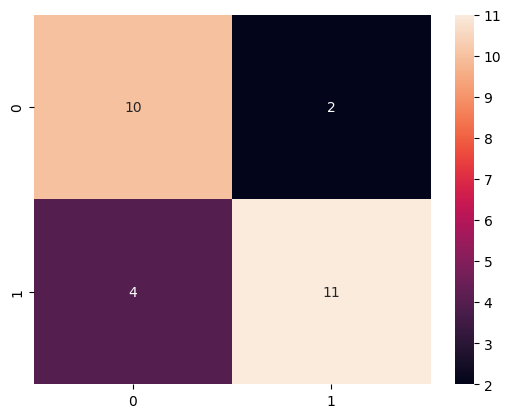

In [20]:
#Importing Confusion Matrix
#Comparing the predictions against the actual observations in y_val

cm = confusion_matrix(y_pred, y_test)
sns.heatmap(cm, annot=True);

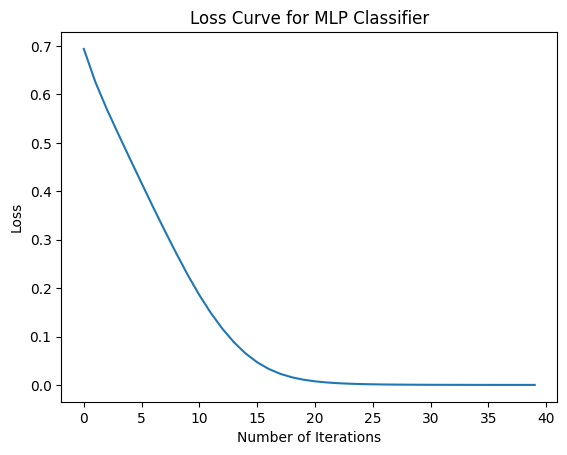

In [21]:
# Plotting graph for MLPClassifier

loss_values = model.loss_curve_
plt.plot(loss_values)
plt.xlabel('Number of Iterations')
plt.ylabel('Loss')
plt.title('Loss Curve for MLP Classifier');


In [22]:
#Save the model to disk

filename = "/content/drive/MyDrive/Job Projects /Ecoli_model.pickle"
pickle.dump(model, open(filename, "wb"))

# Evaluation Summary

## Model Performance Metrics in Medical Context:

* The precision for class 0 (not having E. coli) is 0.83, suggesting that the model is reliable in identifying individuals who do not have E. coli when it predicts a negative result.
* The recall for class 0 is 0.71, indicating that the model correctly identifies 71% of the actual negative (not having E. coli) cases. This could be a concern as it means that 29% of individuals with negative cases could be falsely identified as having E. coli.
* For class 1 (having E. coli), the precision is 0.73, meaning that when the model predicts an individual has E. coli, it is correct approximately 73% of the time. However, there is a risk of misidentifying healthy individuals as having E. coli.
* The recall for class 1 is 0.85, which is crucial in a medical setting as it implies that the model is capable of identifying 85% of the actual positive (having E. coli) cases. This is important to ensure that individuals with E. coli receive the necessary medical attention.

## Confusion Matrix Evaluation

1. True Positives (TP): The top left value (10) represents true positives, indicating that the model correctly identified 10 individuals as having E. coli. This is crucial for ensuring those affected receive appropriate treatment.
2. False Positives (FP): The top right value (2) represents false positives, showing that 2 individuals were incorrectly identified as having E. coli when they did not. While false positives can lead to unnecessary stress and medical interventions, in the context of E. coli detection, a conservative approach that errs on the side of caution is often preferable to missing a diagnosis.
3. False Negatives (FN): The bottom left value (4) represents false negatives, which is of particular concern in medical diagnostics. These are individuals who have E. coli but were incorrectly classified by the model as not having it. False negatives are potentially dangerous as they represent missed diagnoses, which could result in individuals not receiving the treatment they need.
4. True Negatives (TN): The bottom right value (11) represents true negatives, indicating that the model correctly identified 11 individuals as not having E. coli. Accurately identifying individuals who are disease-free is important to prevent unnecessary medical procedures and associated costs.

In the context of disease detection, the model's ability to identify true positives (those with the disease) is of the utmost importance to ensure treatment. The relatively low number of false negatives (4) is positive in this context; however, reducing this number is critical as each false negative could represent a missed case of E. coli. Improving model sensitivity to reduce false negatives should be a priority in future iterations. Additionally, maintaining or improving the true positive rate while minimizing false positives would make the model more reliable and reduce the burden on both patients and healthcare systems.

# Future Considerations

1. **Feature Relevance:** The model's performance could be enhanced by including more relevant features that are strong indicators of E. coli presence, improving its diagnostic accuracy.
2. **Model Calibration:** In a medical diagnosis context, it may be crucial to calibrate the model to reduce false negatives as much as possible, as missing out on diagnosing an actual disease case could have serious health implications.